<div class='Name'>
 <br> <b>Author: </b> Amparo Godoy Pastore
 <br> <b>Date: </b> April 3, 2023
</div>

# Introduction

In this notebook, we will be analyzing image and video data from two videos. The first video is a brain activity map from Erik Duboue's lab, called BrainWideCalciumImage.gif. This video captures the activity in a brain in response to a stimulus. Our goal in analyzing this video is to identify the frame in which the brain responds to the stimulus. The second video (pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short.mkv) is a top view of 5 Mexican cavefish swimming in a tank from the former Cavefish trilab by Alex Keene, Erik Duboue, and Johanna Kowalko. We will be subtracting the background from this video to get a clearer view of the fish. 

# Preliminaries

First, we import the necessary libraries and modules.

In [2]:
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 6,4 # Change default figure size.

# 1. Images

In this section, we modify images.

## 1.1. Loading Images

Let's star by loading the first frame of the brain video. 

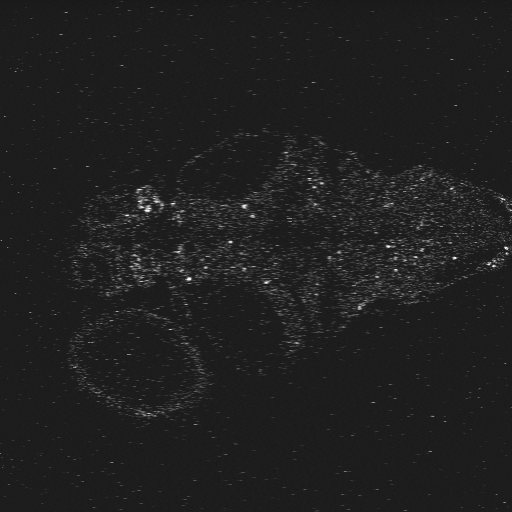

In [3]:
# Load the image
img = Image.open('BrainWideCalciumImage_frame0.png')

# Show the image
display(img)

## 1.2. Accessing, Editing, and Saving Pixel Data.

Here, we save the image as a numpy array so that we can access the pixels, and perform simple pixel editing later on. The brightness values of each pixel range from 0 (black) to 255 (white). As we can see, the image resolution is _512x512_ (we'll edit this later on).

In [5]:
# Convert the image to a numpy array.
img_data = np.array(img)

# Get the shape of the array, aka the resolution of the image
print("Image resolution: ", img_data.shape)

Image resolution:  (512, 512)


<div class="alert alert-block alert-danger">
<b>Task 1</b>
</div>

We are now going to create a copy of the image data and modify the pixels in the bottom left corner to be gray (half way between black and white).

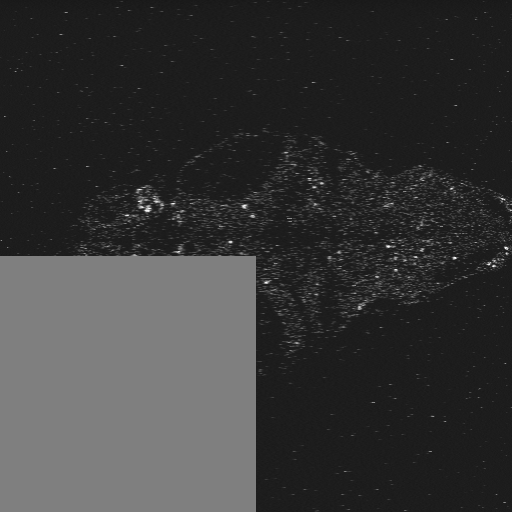

In [23]:
img_data2 = img_data.copy()
img_data2[256:, :256] = 127
img2 = Image.fromarray(img_data2)
display(img2)

<div class="alert alert-block alert-danger">
<b>Task 2</b>
</div>

Now, let's make another copy and change the image resolution to be half of the original, that is four times fewer pixels.

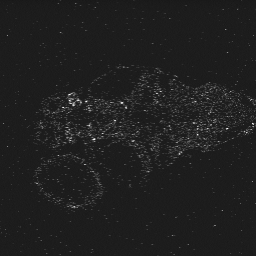

Image resolution:  (256, 256)


In [6]:
img_data3 = img_data.copy()
img_data3 = np.delete(img_data3, np.s_[::2], axis=0)
img_data3 = np.delete(img_data3, np.s_[::2], axis=1)
img3 = Image.fromarray(img_data3)
display(img3)
print("Image resolution: ", img_data3.shape)

## 1.3. Pixel Format and Contrast Enhancement

<div class="alert alert-block alert-danger">
<b>Task 3</b>
</div>

Next, we perform lossless contrast enhancement on the image by spreading out the pixel values to use the entire available range of grayscale values [0,255] without loosing meaningful information. First, we find the darkest and brightest pixels, and then we apply the following linear function to every pixel:
- $f(x)=255*(x-x_1)/(x_2-x_1)$

In [11]:
img_data = np.array(Image.open('BrainWideCalciumImage_frame0.png'))
img_data5 = img_data.copy()

# Find the smallest and largest values in the array, call them x1 and x2
x1 = np.amin(img_data5)
x2 = np.amax(img_data5)

print("Current range of grayscale values: [", x1,", ", x2, "]")

Current range of grayscale values: [ 24 ,  249 ]


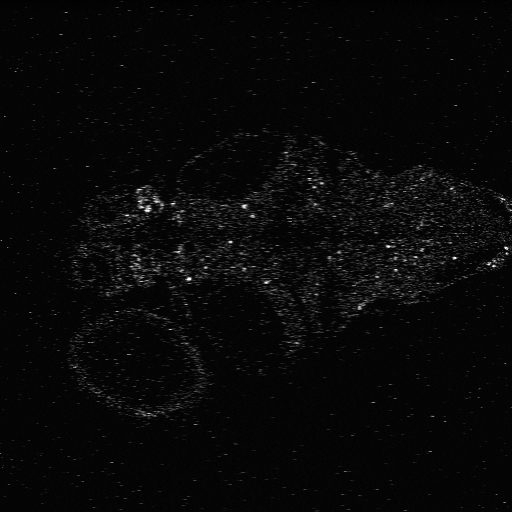

New range of grayscale values: [ 0 ,  255 ]


In [13]:
# Convert to float.
img_data5 = img_data5.astype(float)

# Enhance contrast
img_data5_new = []
for row in img_data5:
    new_col = []
    for value in row:
        new_col.append(255*(value-x1)/(x2-x1))
    img_data5_new.append(new_col)
    
# Convert to array
img_data5_new = np.array(img_data5_new)
    
# Set negative values to 0.
img_data5_new = np.maximum(img_data5_new, 0)

# Set values above 255 to 255.
img_data5_new = np.minimum(img_data5_new, 255)

img5 = Image.fromarray(img_data5_new.astype(np.uint8))
display(img5)

# Find the smallest and largest values in the new array to corroborate
x1_ = int(np.amin(img_data5_new))
x2_ = int(np.amax(img_data5_new))
print("New range of grayscale values: [", x1_,", ", x2_, "]")

As we can see above, the original image was only partially using the available range of grayscale values. The darkest pixel(s) had a value of $24$, and the brightest one(s) $249$. After applying lossless contrast enhancement, the image now uses the entire range. 

# 2. Videos

In this second section, we analyze the videos.

## 2.1. Loading videos

We first need to load the brain activity gif frame by frame and save the data in an array `vid`.

In [17]:
cap = cv2.VideoCapture('BrainWideCalciumImage.gif')

vid = [] # Array that'll save the frames of the video
while cap.isOpened(): 
    ret,frame = cap.read()
    if ret:
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) # Convert to grayscale
        vid.append(gray)
    else:
        break
cap.release() # Close video file

# At this point vid is a list of 2D arrays, one for each frame.
# Convert it to a single 3D array.
vid = np.array(vid)
print("Frames, pixel rows, pixel columns: ", vid.shape)

Frames, pixel rows, pixel colors:  (101, 512, 512)


Now, we have a 101x512x512 array (101 frames, 512 pixel rows, 512 pixel columns) which we can modify.

## 2.2. Average frame and average brightness.

We'll start by extracting a single image which is an average of every fame in the video.

<div class="alert alert-block alert-danger">
<b>Task 4</b>
</div>

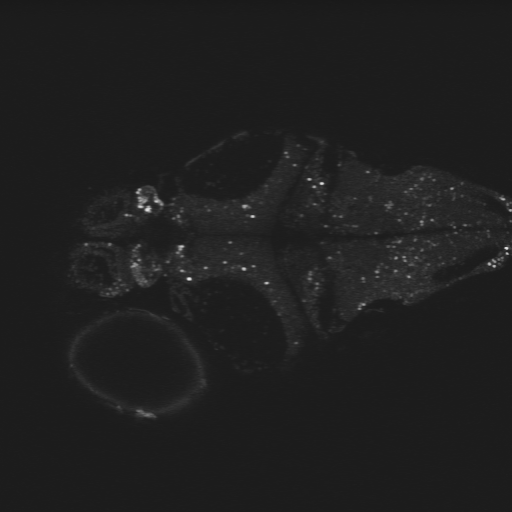

In [25]:
# Get average over time axis
average = np.mean(vid, axis=0)
img_avg = Image.fromarray(average.astype(np.uint8))
display(img_avg)

<div class="alert alert-block alert-danger">
<b>Task 5</b>
</div>

Our goal is to identify at which point in time (frame) the brain reacts to the stimulus. To do that we're going to calculate the average brightness of each frame and plot it against the frame number.

Text(0, 0.5, 'Average brightness')

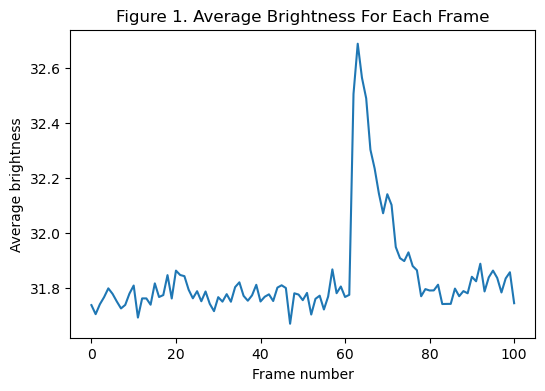

In [26]:
avg_brightness = []
# Calc avg brightness
for frame in vid:
    avg_brightness.append(np.mean(frame))

# 1D array containing all averages
avg_brightness = np.array(avg_brightness)

# Plot
plt.plot(range(len(vid[:])), avg_brightness)
plt.title('Figure 1. Average Brightness For Each Frame')
plt.xlabel('Frame number')
plt.ylabel('Average brightness')

_Figure 1_ shows a pronounced peak between frames 60 and 80, approximately. To make our calculations more precise, let's identify a threshold brightness that is only reached once the reaction starts.

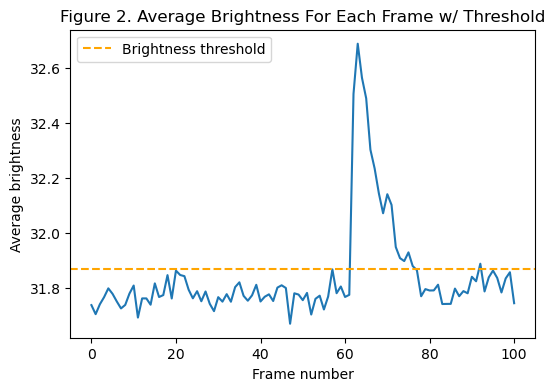

In [33]:
plt.plot(range(len(vid[:])), avg_brightness)
plt.title('Figure 2. Average Brightness For Each Frame w/ Threshold')
plt.xlabel('Frame number')
plt.ylabel('Average brightness')
# Adding threshold line
plt.axhline(np.max(avg_brightness[:60]), color='orange', ls='--', label='Brightness threshold')
plt.legend()

In [30]:
print("Brightness threshold: ", round(np.max(avg_brightness[:60]), 1))

Brightness threshold:  31.9


<div class="alert alert-block alert-danger">
<b>Task 6</b>
</div>

Next, we need to find the first frame at which this threshold is passed.

In [33]:
for i, value in enumerate(avg_brightness):
    if value >= 31.9:
        break
print('Number of the first frame at which the threshold is passed: ', i)

Number of the first frame at which the threshold is passed:  62


The results show that the reaction of the brain to the stimulus starts in frame number 62.

In [51]:
# First, open the video to read.
cap = cv2.VideoCapture('pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short.mkv')
if not cap.isOpened():
    raise Exception('Could not open video.')

# To create a new video, we need to specify a filename, a codec (encoding 
# format), a frame rate, a resolution, and whether the video is color or 
# grayscale. Since we're making a copy, we're going to read most of that 
# information from the input video.
fps    = int(cap.get(cv2.CAP_PROP_FPS))
# fourcc = int(cap.get(cv2.CAP_PROP_FOURCC))
fourcc = cv2.VideoWriter_fourcc(*'mp4v') # This would change the output format to mp4.
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
color  = True

# Now we create an empty output file with the right format.
out = cv2.VideoWriter(filename = 'pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short (copy).mkv', 
                      fourcc = fourcc, 
                      fps = fps, 
                      frameSize = (width,height), #In the constructor gotta pass the dimensions as Columns x Rows
                      isColor = color)

# Reading the entire video into a numpy array often requires to much
# memory, so we're going to read one frame at time, write that frame
# to the output file, then read the next frame into the same numpy
# array variable.

while cap.isOpened():
    ret,frame = cap.read()
    if ret:
        out.write(frame)
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        out.write(gray)
    else:
        break    
cap.release()
out.release()

## 2.3. Background subtraction

When dealing with longer videos, loading them entirely into an array is inefficient. To perform background subtraction on the video of the fish we'll be loading and dealing with one frame at a time. 

<div class="alert alert-block alert-warning" style="background-color:#f0ddcc; color:#663300">
<b>Extra Task 1</b>
</div>

We start by creating and displaying a background frame, which is an average of all the frames in the video.

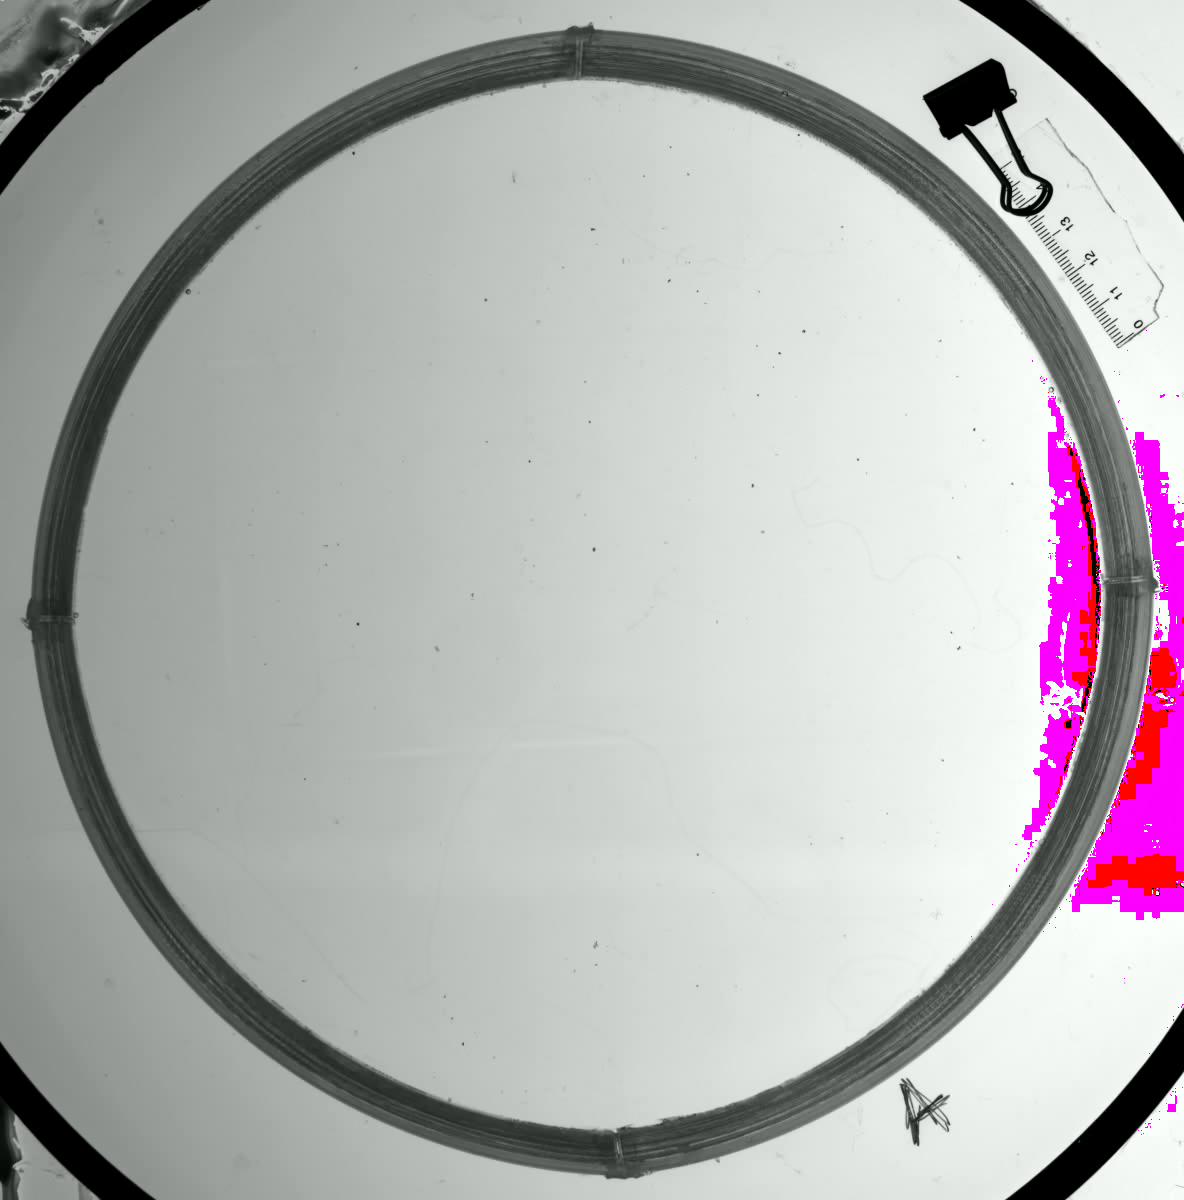

In [34]:
cap = cv2.VideoCapture('pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short (copy).mkv')
frame_sum = np.zeros(shape=(1200,1184,3)) # Set up an array to store the sum of all frames

while cap.isOpened(): # Looping over and reading the frames
    ret,frame = cap.read()
    if ret:
        frame_sum += frame # Sum all frames
    else:
        break
cap.release()

avg = frame_sum / 1200 # Get avergae
avg = Image.fromarray(avg.astype(np.uint8))

display(avg)

<div class="alert alert-block alert-warning" style="background-color:#f0ddcc; color:#663300">
<b>Extra Task 2</b>
</div>

Fianlly, we perform background subtraction on the fish video. The new video is exported to an output file named pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short (new).mkv.

In [58]:
cap = cv2.VideoCapture('pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short (copy).mkv')
background = np.array(avg)
# Now we create an empty output file with the right format.
out = cv2.VideoWriter(filename = 'pa_sat_42dpf_groupB_n5_20210522_2021-05-22-082249_short (new).mkv', 
                      fourcc = fourcc, 
                      fps = fps, 
                      frameSize = (width,height), #In the constructor gotta pass the dimensions as Columns x Rows
                      isColor = color)

while cap.isOpened():
    ret,frame = cap.read()
    if ret:
        sub = frame - background # Subtract background from current frame
        out.write(sub)
        gray = cv2.cvtColor(sub, cv2.COLOR_BGR2GRAY)
        out.write(gray)
    else:
        break    
cap.release()
out.release()

# Conclusion

Our objective in this Jupyter Notebook project was to analyze image and video data from two sources, a brain activity map in response to a stimulus, and Mexican cavefish swimming in a tank. This involved loading, editing, and saving pixel data, as well as contrast enhancement. We successfully demonstrated techniques for accessing and modifying pixels, changing image resolution, and enhancing contrast of frames. We also were able to compute average brightness of each frame in a video, which ultimately allowed us to identify changes in brain activity. Overall, this notebook provided a practical example of how to work with image and video data to make their analysis more efficient and accurate. 